# Analyzing Test Data

The purpose of this analysis is to demonstrate how data can be used to determine which students are at risk of low test scores.  Potentially those students identified as at risk in the future could receive additional support to help those students acheive higher test scores.

The dataset used in this analysis was obtained from Kaggle.  All data is anonymous and has been stripped on any identifiers.  The source of the data was not revealed.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import time
import matplotlib.patches as mpatches

/home/brandon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('exams.csv')

In [3]:
df.shape

(10000, 8)

In [4]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group C,some college,standard,completed,82,91,90
1,female,group D,associate's degree,standard,none,69,69,75
2,female,group A,bachelor's degree,standard,completed,72,77,82
3,female,group C,master's degree,standard,none,59,78,73
4,male,group C,high school,standard,completed,64,61,54


In [5]:
dff = df

In [6]:
dff = dff.rename({'race/ethnicity':'race', 'parental level of education':'parent_edu', 'lunch':'fr_lunch',
            'test preparation course':'test_prep', 'math score':'math', 'reading score':'reading',
            'writing score':'writing'}, axis='columns')
dff.gender = np.where(dff.gender == 'female', 0, 1)
dff.test_prep = np.where(dff.test_prep == 'completed', 1, 0)
dff.fr_lunch = np.where(dff.fr_lunch == 'standard', 0, 1)

In [7]:
print('Races/Ethnicities')
print(dff.race.unique())
print('\nEducation Levels')
print(dff.parent_edu.unique())

Races/Ethnicities
['group C' 'group D' 'group A' 'group B' 'group E']

Education Levels
['some college' "associate's degree" "bachelor's degree" "master's degree"
 'high school' 'some high school']


In [8]:
dff = dff.replace({'parent_edu' : {'some high school':1, 'high school':2, 'some college':3,
                                   'associate\'s degree':4, 'bachelor\'s degree':5,
                                   'master\'s degree': 6}})

## Math Score Distributions by Race/Ethnicity Group

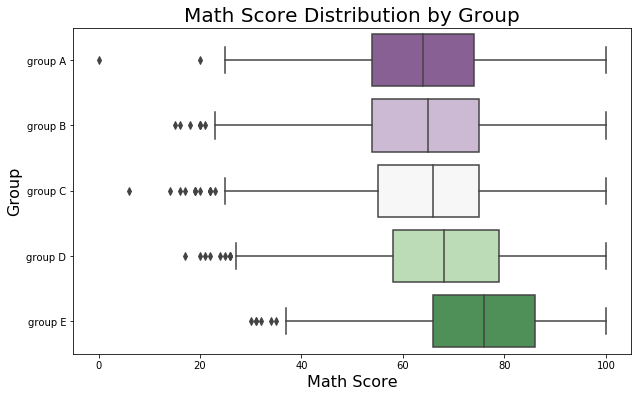

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='math', y='race', data=dff, palette='PRGn', order=['group A', 'group B', 'group C',
                                                                'group D', 'group E'])
plt.title('Math Score Distribution by Group', size=20)
plt.xlabel('Math Score', size=16)
plt.ylabel('Group', size=16)
plt.show()

In [10]:
#Creating new variables from race/ethnicity groups

dff = dff.replace({'race' : {'group A':'A', 'group B':'B', 'group C':'C', 'group D':'D', 'group E':'E'}})
new_variable = pd.get_dummies(dff['race'], prefix='group')
dff = dff.join(new_variable)
dff = dff.drop(['race'], axis=1)

In [11]:
dff.head()

,gender,parent_edu,fr_lunch,test_prep,math,reading,writing,group_A,group_B,group_C,group_D,group_E
0,0,3,0,1,82,91,90,0,0,1,0,0
1,0,4,0,0,69,69,75,0,0,0,1,0
2,0,5,0,1,72,77,82,1,0,0,0,0
3,0,6,0,0,59,78,73,0,0,1,0,0
4,1,2,0,1,64,61,54,0,0,1,0,0


This dataset is very clean.  All the values seem to be reasonable and there are no null values.

## Correlation Between Variables

In [12]:
dff.corr()

,gender,parent_edu,fr_lunch,test_prep,math,reading,writing,group_A,group_B,group_C,group_D,group_E
gender,1.000000,0.008840,-0.006814,-0.009507,0.159589,-0.239161,-0.294359,-0.009416,-0.000840,0.011448,0.000938,-0.008203
parent_edu,0.008840,1.000000,-0.007483,-0.007229,0.201492,0.193322,0.227020,-0.015085,-0.005141,0.004311,0.014033,-0.005817
fr_lunch,-0.006814,-0.007483,1.000000,-0.002657,-0.385709,-0.272220,-0.288999,-0.008583,0.000390,0.009407,-0.004848,-0.000393
test_prep,-0.009507,-0.007229,-0.002657,1.000000,0.147303,0.219303,0.301842,-0.006222,0.005398,-0.004589,0.014522,-0.013566
math,0.159589,0.201492,-0.385709,0.147303,1.000000,0.819805,0.808001,-0.060994,-0.094037,-0.088955,0.036528,0.226490
reading,-0.239161,0.193322,-0.272220,0.219303,0.819805,1.000000,0.953011,-0.040382,-0.069419,-0.051896,0.042453,0.126390
writing,-0.294359,0.227020,-0.288999,0.301842,0.808001,0.953011,1.000000,-0.047323,-0.082608,-0.071706,0.097798,0.104326
group_A,-0.009416,-0.015085,-0.008583,-0.006222,-0.060994,-0.040382,-0.047323,1.000000,-0.147597,-0.192119,-0.167402,-0.117432
group_B,-0.000840,-0.005141,0.000390,0.005398,-0.094037,-0.069419,-0.082608,-0.147597,1.000000,-0.348722,-0.303857,-0.213155
group_C,0.011448,0.004311,0.009407,-0.004589,-0.088955,-0.051896,-0.071706,-0.192119,-0.348722,1.000000,-0.395513,-0.277451


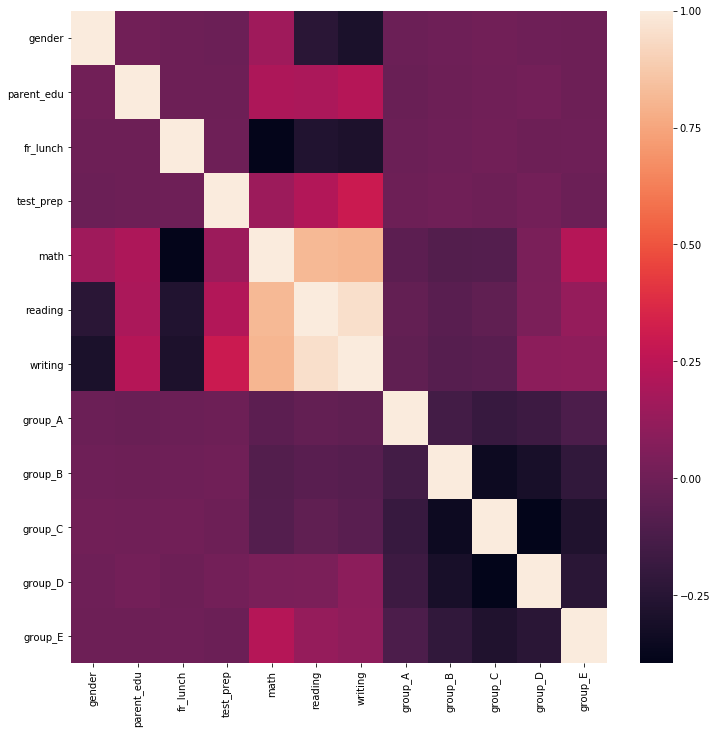

In [13]:
plt.figure(figsize=(12,12))
sns.heatmap(dff.corr())

## Math Scores vs. Reading Scores

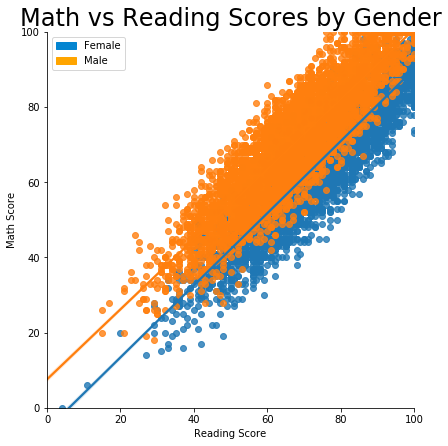

In [14]:
sns.lmplot(x='reading', y='math', hue='gender', data=dff, height=6, legend=False)
plt.title('Math vs Reading Scores by Gender', size=20)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Reading Score')
plt.ylabel('Math Score')
patch1 = mpatches.Patch(color='xkcd:cerulean', label='Female')
patch2 = mpatches.Patch(color='orange', label='Male')
plt.legend(handles=[patch1, patch2])
plt.show()

## Creating Predictive Model for Math Score (not using other scores)

In [15]:
y = dff['math']
X = dff.drop(['math', 'reading', 'writing'], axis=1)

In [16]:
# Linear Model

regr = linear_model.LinearRegression()
time1 = time.time()
regr.fit(X, y)

print('R-squared Value')
print(regr.score(X, y))

kf = KFold(n_splits=5)
kf.get_n_splits(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scores = []
for train, test in kf.split(X):
    regr.fit(X.iloc[train], y.iloc[train])
    scores.append(regr.score(X.iloc[test], y.iloc[test]))
    
print('\n')
print('--Average Cross Validation Score--')
print(np.mean(scores))
print('\n')
print('--Runtime: %s seconds--' % (time.time() - time1))

R-squared Value
0.2961281818606438


--Average Cross Validation Score--
0.29413118172005304


--Runtime: 0.026340246200561523 seconds--


In [17]:
# Gradient-boosting Model

time1 = time.time()
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

print('R-squared Value')
print(clf.score(X, y))

scores = []
for train, test in kf.split(X):
    clf.fit(X.iloc[train], y.iloc[train])
    scores.append(clf.score(X.iloc[test], y.iloc[test]))
    
print('\n')
print('--Average Cross Validation Score--')
print(np.mean(scores))
print('\n')
print('--Runtime: %s seconds--' % (time.time() - time1))

R-squared Value
0.30440460990178053


--Average Cross Validation Score--
0.2856107204940178


--Runtime: 15.926248788833618 seconds--


## Model Value

These model have some value, as the R-squared value shows that a significant portion of the variance in the data has been accounted for in the models.  However, only about 30% of the variance has been accounted for, so this model should be used with caution.  

## Creating Predictive Model for Math Score (using other scores)

In [18]:
y = dff['math']
X = dff.drop(['math'], axis=1)

In [19]:
# Linear Model

regr = linear_model.LinearRegression()
time1 = time.time()
regr.fit(X, y)

print('R-squared Value')
print(regr.score(X, y))

kf = KFold(n_splits=5)
kf.get_n_splits(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scores = []
for train, test in kf.split(X):
    regr.fit(X.iloc[train], y.iloc[train])
    scores.append(regr.score(X.iloc[test], y.iloc[test]))
    
print('\n')
print('--Average Cross Validation Score--')
print(np.mean(scores))
print('\n')
print('--Runtime: %s seconds--' % (time.time() - time1))

R-squared Value
0.8777961995648604


--Average Cross Validation Score--
0.8774444364700777


--Runtime: 0.02947998046875 seconds--


In [20]:
# Gradient-boosting Model

time1 = time.time()
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

print('R-squared Value')
print(clf.score(X, y))

scores = []
for train, test in kf.split(X):
    clf.fit(X.iloc[train], y.iloc[train])
    scores.append(clf.score(X.iloc[test], y.iloc[test]))
    
print('\n')
print('--Average Cross Validation Score--')
print(np.mean(scores))
print('\n')
print('--Runtime: %s seconds--' % (time.time() - time1))

R-squared Value
0.8842767871228173


--Average Cross Validation Score--
0.8748327441477665


--Runtime: 19.734506845474243 seconds--


## Model Value

These models are able to account for most of the variance in the data (88%).  However, they use the test scores from the other subjects, which could be problematic.  The scores from the other subject areas might not be available.  Ideally, more variables could be created from additional data that is available to the schools and those supporteing students, so that better identification of at risk students could be possible without relying on test scores that might not yet be available.

Of the two types of models I tried, the linear regression model is better for a couple of reasons.  The models show similar accuracy, but the R-squared value for linear model is slightly more consistent in cross-validation.  More importantly, the linear model trains about 50 times as fast.